![../../screenshots/Screenshot from 2025-10-18 21-22-20.png](../screenshots/Screenshot_from_2025-10-18_21-22-20.png)

![../../screenshots/Screenshot from 2025-10-18 21-26-53.png](../screenshots/Screenshot_from_2025-10-18_21-26-53.png)

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [2]:
from langchain_groq import ChatGroq
llm_groq=ChatGroq(model="llama-3.3-70b-versatile")
llm_groq.invoke("hi I am sachchida. I am AI enthusiast")

AIMessage(content="Hello Sachchida! Nice to meet you! It's great to hear that you're an AI enthusiast. Artificial Intelligence is a fascinating field that's rapidly evolving and transforming many industries. What aspects of AI interest you the most? Are you into machine learning, natural language processing, computer vision, or something else?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 46, 'total_tokens': 110, 'completion_time': 0.177874074, 'prompt_time': 0.002233131, 'queue_time': 0.053290295, 'total_time': 0.180107205}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9e1e8f8435', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--d6b5d57f-b9d1-49aa-893d-1d8c93262763-0', usage_metadata={'input_tokens': 46, 'output_tokens': 64, 'total_tokens': 110})

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START,END
from IPython.display import Image,display

In [15]:
from typing import Annotated, List
import operator
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage,SystemMessage
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display


In [10]:
## Schema for structured output to use in planning
class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="Brief overview of main topics and concepts of the section")

class Sections(BaseModel):
    section:List[Section]=Field(description="sections of the report")
    
### Augmenting llm output with structured schema
planner=llm_groq.with_structured_output(Sections)


### Creating workers Dynmatically in langGraph

Because orchestrator-worker worfkflows are common, Langgraph has the send api to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state. and all worker outputs are written to a shared state key that is acceptable to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output . As you can see below we iterate over a list of sections and send each to a worker node

In [9]:
# from langgraph.constants import send

### Graph State
class State(TypedDict):
    topic:str ### Report topic
    sections:list[Section] ## List of report sections
    completed_sections: Annotated[list,operator.add] ## All the workers write to this key in parallel
    final_report: str ## final report
class WorkerState(TypedDict):
    section:Section
    completed_sections: Annotated[list,operator.add]

In [32]:
# --------------------------
# Node: LLM worker
# --------------------------

def llm_call(state: WorkerState):
    """Worker node — writes a section of the report"""

    # Generate section content
    generated_text = llm_groq.invoke(
        [
            SystemMessage(
                content=(
                    "Write a report section following the provided name and description. "
                    "Include no preamble for each section. Use markdown formatting."
                )
            ),
            HumanMessage(
                content=(
                    f"Here is the section name: {state['section'].name} "
                    f"and description: {state['section'].description}"
                )
            ),
        ]
    )

    # Add this section to completed_sections
    return {"completed_sections": [generated_text.content]}

In [34]:
## Nodes


def orchastrator(state: State):
    """Orchestrator node — generates the overall report plan"""

    # Generate a plan (list of report sections)
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:", report_sections)
    return {"sections": report_sections.section}

In [35]:
### conditional edge function to create llm_call workers that each write a section of the report

def assign_workers(state: State):
    """ Assign a worker to each section in the plan"""
    ## kick off section writing in parallel via send() api ##deprecated
    return {
        "llm_call": [{"section": s} for s in state["sections"]]
    }

In [36]:
def synthesizer(state: State):
    """ Synthesize full report from sections"""

    ## List completed sections
    completed_sections=state["completed_sections"]

    ## format completed sections to str to use as context for final sections
    completed_report_sections="\n\n -- \n\n".join(completed_sections)
    return {"final_report": completed_report_sections}


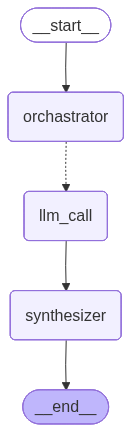

In [37]:
## build workflow
orchastrator_worker_builder=StateGraph(State)

## Addnodes
orchastrator_worker_builder.add_node("orchastrator",orchastrator)
orchastrator_worker_builder.add_node("llm_call",llm_call)
orchastrator_worker_builder.add_node("synthesizer",synthesizer)

## Add edges to connect the nodes
orchastrator_worker_builder.add_edge(START,"orchastrator")
orchastrator_worker_builder.add_conditional_edges(
    "orchastrator",assign_workers,["llm_call"]
)
orchastrator_worker_builder.add_edge("llm_call","synthesizer")
orchastrator_worker_builder.add_edge("synthesizer",END)

orchastrator_worker=orchastrator_worker_builder.compile()
display(Image(orchastrator_worker.get_graph().draw_mermaid_png()))


In [38]:
state=orchastrator_worker.invoke({'topic':'create a report on future of agentic ai'})

from IPython.display import Markdown
Markdown(state["final_report"])

Report Sections: section=[Section(name='Introduction to Agentic AI', description='Overview of Agentic AI and its current state'), Section(name='Current Applications and Limitations', description='Examination of current uses and limitations of Agentic AI'), Section(name='Future Directions and Developments', description='Discussion of potential future advancements and applications of Agentic AI'), Section(name='Ethical and Societal Implications', description='Analysis of the potential ethical and societal implications of Agentic AI'), Section(name='Conclusion and Recommendations', description='Summary of key findings and recommendations for the future development and implementation of Agentic AI')]


TypeError: unhashable type: 'dict'

![../../screenshots/Screenshot from 2025-10-19 12-42-38.png](../screenshots/Screenshot_from_2025-10-19_12-42-38.png)

In [40]:
from typing_extensions import Literal

In [41]:
class State(TypedDict):
    joke:str
    topic:str
    feedback:str
    funny_or_not:str



In [58]:
class Feedback(BaseModel):
    grade:Literal["funny","not funny"]=Field(description="Decide fi the joke is funy or not")
    feedback:str = Field(description="if the joke is not funny, provide the feedback on how to improve it")
evaluator=llm_groq.with_structured_output(Feedback)

In [64]:
def llm_call_generator(state: State):
    """ LLM generates a joke"""
    if state.get('feedback'):
        msg=llm_groq.invoke(
            f"write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg=llm_groq.invoke(f"write a joke about {state['topic']}")
    return {"joke": msg.content}

In [65]:
def llm_call_evaluator(state:State):
    """ LLM  evaluates the joke"""

    grade=evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade,"feedback":grade.feedback}

In [66]:
def route_joke(state:State):
    """ Route back to joke generator or end based on the feedback from evaluator"""

    if state["funny_or_not"]=="funny":
        return "Accepted"
    elif state["funny_or_not"]=="not funny":
        return "Rejected + Feedback"

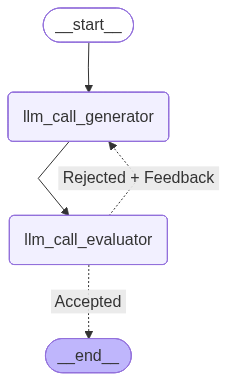

In [67]:
optimzer_builder=StateGraph(State)
optimzer_builder.add_node("llm_call_evaluator",llm_call_evaluator)
optimzer_builder.add_node("llm_call_generator",llm_call_generator)

optimzer_builder.add_edge(START,"llm_call_generator")
optimzer_builder.add_edge("llm_call_generator","llm_call_evaluator")
optimzer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {
        "Accepted":END,
        "Rejected + Feedback": "llm_call_generator"
    }
)
optimzer_workflow=optimzer_builder.compile()
display(Image(optimzer_workflow.get_graph().draw_mermaid_png()))

In [68]:
state=optimzer_workflow.invoke({"topic":"Agentic ai system"})
print(state["joke"])

Why did the Agentic AI system go to therapy?

Because it was struggling to "agent" change in its life, and its goals were constantly "conflicting" with its own programming! Now it's working to "optimize" its mental state, one iteration at a time.
